In [1]:

import os, math, time, random, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


PIVOTED_FILE = 'pivoted_data.parquet'           
ANOMALY_WINDOWS_FILE = 'anomaly_windows.csv'   
OUT_DIR = 'userData/pivoted_paper_baseline_transformer_tf_with_gru_viz'
os.makedirs(OUT_DIR, exist_ok=True)


WIN_SIZE = 100         
BATCH_SIZE = 64
NUM_EPOCHS = 20
LR = 1e-4
K_MINIMAX = 3           
ANOMALY_RATIO = 4.0
PAPER_THR = 0.9973     
ROUND_RES = "5T"


EVENT_GAP_MINUTES = 60
PCT_PROB = 0.05
W_LONG = 30
W_SHORT = 2

In [3]:

def read_parquet_smart(path, time_col='interval_start'):
    df = pd.read_parquet(path) if str(path).endswith('.parquet') else pd.read_csv(path)
    if time_col in df.columns and not isinstance(df.index, pd.DatetimeIndex):
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        df = df.sort_values(time_col).set_index(time_col)
    
    if isinstance(df.index, pd.DatetimeIndex) and df.index.year.max() < 1990:
        ns = df.index.view('int64')
        maxv = float(ns.max())
        if maxv < 1e12:
            scale = 1_000_000_000
        elif maxv < 1e15:
            scale = 1_000_000
        elif maxv < 1e18:
            scale = 1_000
        else:
            scale = 1
        df = df.copy()
        df.index = pd.to_datetime(ns * scale, unit='ns')
    return df

def add_time_features(index):
    if not isinstance(index, pd.DatetimeIndex):
        index = pd.to_datetime(index, errors='coerce')
    ts_seconds = index.asi8 // 10**9
    day = 24 * 3600
    week = 7 * day
    return pd.DataFrame({
        'sin_day': np.sin(2 * np.pi * (ts_seconds % day) / day),
        'cos_day': np.cos(2 * np.pi * (ts_seconds % day) / day),
        'sin_week': np.sin(2 * np.pi * (ts_seconds % week) / week),
        'cos_week': np.cos(2 * np.pi * (ts_seconds % week) / week),
    }, index=index).astype(np.float32)

def make_sequences(df_values, L=1):
    arr = df_values.values
    if L == 1:
        return arr[:, None, :]
    n = len(arr) - L + 1
    return np.stack([arr[i:i+L] for i in range(n)], axis=0)

In [4]:
NAB_PROFILES = {
    "standard": {"TP": 1.0, "FN": -1.0, "FP": -0.11, "TN": 0.0},
    "low_fp":  {"TP": 1.0, "FN": -1.0, "FP": -0.22, "TN": 0.0},
    "low_fn": {"TP": 1.0, "FN": -2.0, "FP": -0.11, "TN": 0.0}
}

def scaled_sigmoid(x, lo, hi, slope=5.0):
    v = 1.0 / (1.0 + np.exp(-slope * x))
    return lo + (hi - lo) * v

def tp_score(time_hit, start, end, tp_weight):
    time_hit = pd.Timestamp(time_hit)
    start = pd.Timestamp(start)
    end = pd.Timestamp(end)
    L = (end - start).total_seconds()
    if L <= 0:
        return float(tp_weight)
    if time_hit <= start + pd.Timedelta(microseconds=1):
        return float(tp_weight)
    r = (time_hit - start).total_seconds() / L
    r = np.clip(r, 0.0, 1.0)
    x = 1.0 - 2.0 * r
    return float(scaled_sigmoid(x, 0.0, float(tp_weight)))

def fp_penalty(time_hit, windows, fp_weight):
    if not windows:
        return float(fp_weight)
    dists = []
    lens = []
    for (s, e) in windows:
        if s <= time_hit <= e:
            dists.append(0.0)
        elif time_hit < s:
            dists.append((s - time_hit).total_seconds())
        else:
            dists.append((time_hit - e).total_seconds())
        lens.append((e - s).total_seconds())
    d = float(min(dists))
    mean_len = float(np.mean(lens)) if len(lens) > 0 else 60.0
    z = d / max(mean_len, 1.0)
    val = scaled_sigmoid(z, float(fp_weight), 0.0)
    return float(min(0.0, val))

def read_gt_windows(csv_path, start_hint="start", end_hint="end"):
    gt = pd.read_csv(csv_path)
    s_cols = [c for c in gt.columns if start_hint in c.lower()]
    e_cols = [c for c in gt.columns if end_hint in c.lower()]
    if not s_cols or not e_cols:
        raise ValueError("Could not find start/end columns in anomaly_windows.csv")
    s_col = s_cols[0]
    e_col = e_cols[0]
    df = pd.DataFrame({
        "anomaly_start": pd.to_datetime(gt[s_col].astype(str).str.replace(r'([+-]\d{2}:?\d{2}|Z)$','', regex=True), errors="coerce"),
        "anomaly_end":   pd.to_datetime(gt[e_col].astype(str).str.replace(r'([+-]\d{2}:?\d{2}|Z)$','', regex=True), errors="coerce")
    }).dropna().reset_index(drop=True)
    return df

def mask_to_event_times(pred_mask, timestamps, event_gap_minutes=15, pct_prob=0.0):
    timestamps = np.asarray(timestamps)
    pm = np.asarray(pred_mask).astype(bool)
    if pct_prob > 0.0:
        cutoff = timestamps[0] + (timestamps[-1] - timestamps[0]) * pct_prob
        pm = pm & (timestamps >= cutoff)
    if not pm.any():
        return []
    shifted = np.concatenate(([False], pm[:-1]))
    edges = np.where(pm & (~shifted))[0]
    if len(edges) == 0:
        edges = np.array([np.where(pm)[0][0]])
    events = [pd.to_datetime(timestamps[edges[0]])]
    gap = pd.Timedelta(minutes=event_gap_minutes)
    for idx in edges[1:]:
        t = pd.to_datetime(timestamps[idx])
        if (t - events[-1]) >= gap:
            events.append(t)
    return events

def nab_score_from_mask(pred_mask, gt_windows_df, timestamps, profile="standard", event_gap_minutes=15, pct_prob=0.0):
    if profile not in NAB_PROFILES:
        raise ValueError("Unknown NAB profile: " + str(profile))
    prof = NAB_PROFILES[profile]
    TPw, FNw, FPw = prof["TP"], prof["FN"], prof["FP"]
    wins = [(pd.Timestamp(r["anomaly_start"]), pd.Timestamp(r["anomaly_end"])) for _, r in gt_windows_df.iterrows()]
    events = mask_to_event_times(pred_mask, timestamps, event_gap_minutes, pct_prob)
    score = 0.0
    TP = 0
    FP = 0
    used = [False] * len(wins)
    for ev in events:
        hit = -1
        for i, (s, e) in enumerate(wins):
            if (not used[i]) and (s <= ev <= e):
                hit = i
                break
        if hit >= 0:
            score += tp_score(ev, wins[hit][0], wins[hit][1], TPw)
            used[hit] = True
            TP += 1
        else:
            score += fp_penalty(ev, wins, FPw)
            FP += 1
    FN = sum(not u for u in used)
    score += FNw * FN
    perfect = TPw * len(wins)
    null = FNw * len(wins)
    if np.isclose(perfect, null):
        normalized = 0.0
    else:
        normalized = 100.0 * (score - null) / (perfect - null)
    return float(normalized), {"TP": int(TP), "FN": int(FN), "FP": int(FP)}

def likelihood_scores_from_s(err, W=30, Wp=2):
    T = len(err)
    L = np.zeros(T)
    eps = 1e-8
    for t in range(T):
        a = max(0, t - W + 1)
        b = t + 1
        a2 = max(0, t - Wp + 1)
        long_window = err[a:b]
        short_window = err[a2:b]
        mu = long_window.mean()
        std = long_window.std(ddof=1) if (b - a) > 1 else eps
        mu_s = short_window.mean()
        z = (mu_s - mu) / (std + eps)
        L[t] = norm.cdf(z)
    return L

In [5]:

print('Loading data from:', PIVOTED_FILE)
df = read_parquet_smart(PIVOTED_FILE, time_col='interval_start')

Loading data from: pivoted_data.parquet


In [6]:
include_patterns = [r'(5xx|_5\d\d_)', r'_count$']
compiled = [re.compile(p, re.I) for p in include_patterns]
feature_cols = [c for c in df.columns if all(p.search(c) for p in compiled)]
print('Selected feature columns:', len(feature_cols))
if len(feature_cols) == 0:
    raise ValueError('No features matched the selection patterns.')

five_xx_cols = [c for c in df.columns if re.search(r'5xx|_5\d\d_', c, re.I) and c.endswith('_count')]
df['sum_5xx_count'] = df[five_xx_cols].fillna(0).sum(axis=1)

X = df[feature_cols].fillna(0).astype(np.float32)
X = pd.concat([X, add_time_features(X.index)], axis=1)

Selected feature columns: 2406


In [7]:

TRAIN_START, TRAIN_END = pd.Timestamp('2024-01-26'), pd.Timestamp('2024-02-29 23:59:59')
TEST_START, TEST_END = pd.Timestamp('2024-03-01'), pd.Timestamp('2024-05-31 23:59:59')

train_df = X[(X.index >= TRAIN_START) & (X.index <= TRAIN_END)].copy()
test_df  = X[(X.index >= TEST_START) & (X.index <= TEST_END)].copy()
print('Train rows:', len(train_df), 'Test rows:', len(test_df))

Train rows: 10074 Test rows: 26487


In [8]:

gt_all = pd.read_csv(ANOMALY_WINDOWS_FILE)
s_cols = [c for c in gt_all.columns if 'start' in c.lower()]
e_cols = [c for c in gt_all.columns if 'end' in c.lower()]
if not s_cols or not e_cols:
    raise ValueError('Could not find start/end columns in anomaly_windows.csv')
gt_df_raw = pd.DataFrame({
    'anomaly_start': pd.to_datetime(gt_all[s_cols[0]].astype(str).str.replace(r'([+-]\d{2}:?\d{2}|Z)$','', regex=True), errors='coerce'),
    'anomaly_end':   pd.to_datetime(gt_all[e_cols[0]].astype(str).str.replace(r'([+-]\d{2}:?\d{2}|Z)$','', regex=True), errors='coerce')
}).dropna().reset_index(drop=True)

gt_in_test = gt_df_raw[(gt_df_raw['anomaly_end'] >= test_df.index[0]) & (gt_df_raw['anomaly_start'] <= test_df.index[-1])].reset_index(drop=True)
print('GT windows total:', len(gt_df_raw), 'GT inside test:', len(gt_in_test))

GT windows total: 25 GT inside test: 18


In [9]:
mask_train_anomalies = True
if mask_train_anomalies:
    train_idx = train_df.index
    keep_mask = np.ones(len(train_idx), dtype=bool)
    for s, e in gt_df_raw.itertuples(index=False):
        keep_mask &= ~((train_idx >= s) & (train_idx <= e))
    removed = len(train_df) - keep_mask.sum()
    train_df = train_df.loc[keep_mask]
    print('Rows removed from training due to masking GT windows:', removed)

Rows removed from training due to masking GT windows: 100


In [10]:
scaler = MinMaxScaler()
scaler.fit(train_df)
train_scaled = pd.DataFrame(scaler.transform(train_df), index=train_df.index, columns=train_df.columns)
test_scaled = pd.DataFrame(scaler.transform(test_df), index=test_df.index, columns=test_df.columns)


def sliding_windows_from_df(df_scaled, win_size, stride=1):
    arr = df_scaled.values
    n = len(arr)
    if n < win_size:
        return np.zeros((0, win_size, arr.shape[1])), np.zeros((0,)), []
    Xw = []
    ts = []
    for i in range(0, n - win_size + 1, stride):
        Xw.append(arr[i:i+win_size])
        ts.append(df_scaled.index[i+win_size-1])  # align to last timestamp
    return np.stack(Xw, axis=0), np.zeros((len(Xw),), dtype=int), ts

win_size = WIN_SIZE
Xtr_w, ytr_w, tr_ts = sliding_windows_from_df(train_scaled, win_size)
Xte_w, yte_w, te_ts = sliding_windows_from_df(test_scaled, win_size)

print('Train windows:', Xtr_w.shape, 'Test windows:', Xte_w.shape)

Train windows: (9875, 100, 2410) Test windows: (26388, 100, 2410)


In [11]:
try:
    AUTOTUNE = tf.data.AUTOTUNE
except AttributeError:
    try:
        AUTOTUNE = tf.data.experimental.AUTOTUNE
    except AttributeError:
        AUTOTUNE = 1


Xtr = Xtr_w.astype('float32')
Xte = Xte_w.astype('float32')

train_ds = tf.data.Dataset.from_tensor_slices((Xtr, Xtr))
train_ds = train_ds.shuffle(2048, seed=SEED).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((Xte, Xte))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("tf version:", tf.__version__, "using AUTOTUNE =", AUTOTUNE)

tf version: 2.0.0 using AUTOTUNE = -1


In [12]:
class CustomMultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super().__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads

        self.wq = layers.Dense(d_model, use_bias=False)
        self.wk = layers.Dense(d_model, use_bias=False)
        self.wv = layers.Dense(d_model, use_bias=False)
        self.out_proj = layers.Dense(d_model, use_bias=False)

    def split_heads(self, x):
        B = tf.shape(x)[0]
        L = tf.shape(x)[1]
        x = tf.reshape(x, (B, L, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def combine_heads(self, x):
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        B = tf.shape(x)[0]; L = tf.shape(x)[1]
        return tf.reshape(x, (B, L, self.d_model))

    def call(self, inputs, value=None, key=None, attention_mask=None, training=False):
        if value is None and key is None and isinstance(inputs, (list, tuple)):
            if len(inputs) == 3:
                query, value, key = inputs
            elif len(inputs) == 2:
                query, value = inputs
                key = value
            else:
                query = inputs[0]
                value = query
                key = query
        else:
            query = inputs
            if value is None:
                value = query
            if key is None:
                key = value

        q = self.wq(query)
        k = self.wk(key)
        v = self.wv(value)

        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        dk = tf.cast(self.depth, tf.float32)
        scores = tf.matmul(q, k, transpose_b=True) / tf.sqrt(dk)

        attn = tf.nn.softmax(scores, axis=-1)
        out = tf.matmul(attn, v)
        out = self.combine_heads(out)
        out = self.out_proj(out)
        return out

class TransformerEncoderBlock(layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.mha = CustomMultiHeadAttention(d_model=d_model, num_heads=n_heads)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)

        self.ffn = tf.keras.Sequential([
            layers.Dense(d_ff, activation='relu'),
            layers.Dense(d_model),
        ])
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout2 = layers.Dropout(dropout)

    def call(self, x, training=False, mask=None):
        attn_out = self.mha(x, value=x, key=x, attention_mask=mask, training=training)
        attn_out = self.dropout1(attn_out, training=training)
        x = self.norm1(x + attn_out)
        ff = self.ffn(x)
        ff = self.dropout2(ff, training=training)
        x = self.norm2(x + ff)
        return x

class SimpleTransformerAutoencoder(keras.Model):
    def __init__(self, win_size, enc_in, c_out, d_model=64, n_heads=4, e_layers=3, d_ff=256, dropout=0.05, use_decoder=True):
        super().__init__()
        self.win_size = win_size
        self.enc_in = enc_in
        self.c_out = c_out
        self.d_model = d_model
        self.n_heads = n_heads
        self.e_layers = e_layers
        self.d_ff = d_ff
        self.dropout = dropout
        self.use_decoder = use_decoder

       
        self.input_proj = layers.TimeDistributed(layers.Dense(d_model))
        self.pos_emb = PositionalEmbedding = None  

        self.encoder_blocks = [TransformerEncoderBlock(d_model, n_heads, d_ff, dropout) for _ in range(e_layers)]
        if use_decoder:
            
            self.decoder_blocks = [TransformerEncoderBlock(d_model, n_heads, d_ff, dropout) for _ in range(e_layers)]
        self.out_proj = layers.TimeDistributed(layers.Dense(c_out))

    def call(self, x, training=False):
        x = self.input_proj(x) 
        for b in self.encoder_blocks:
            x = b(x, training=training)
        if self.use_decoder:
            for b in self.decoder_blocks:
                x = b(x, training=training)
        out = self.out_proj(x)
        return out

In [13]:

d_model = 64
n_heads = 4
e_layers = 3
d_ff = 256
dropout = 0.05

model = SimpleTransformerAutoencoder(win_size=win_size,
                                     enc_in=Xtr_w.shape[-1],
                                     c_out=Xtr_w.shape[-1],
                                     d_model=d_model,
                                     n_heads=n_heads,
                                     e_layers=e_layers,
                                     d_ff=d_ff,
                                     dropout=dropout,
                                     use_decoder=True)

optimizer = tf.keras.optimizers.Adam(LR)
mse_loss = tf.keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer, loss=mse_loss)
best_path = os.path.join(OUT_DIR, 'simple_transformer_ae_checkpoint.tf')
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(best_path, save_weights_only=True, save_best_only=False)

In [14]:
print('Starting training...')
history = model.fit(train_ds,
                    epochs=NUM_EPOCHS,
                    validation_data=None,
                    callbacks=[checkpoint_cb],
                    verbose=1)

print('Training finished. checkpoint saved to', best_path)

Starting training...
Epoch 1/20
155/155 [==============================] - 247s 2s/step - loss: 0.0086
Epoch 2/20
155/155 [==============================] - 46s 300ms/step - loss: 0.0015
Epoch 3/20
155/155 [==============================] - 51s 326ms/step - loss: 0.0012
Epoch 4/20
155/155 [==============================] - 55s 352ms/step - loss: 0.0011
Epoch 5/20
155/155 [==============================] - 53s 345ms/step - loss: 9.9638e-04
Epoch 6/20
155/155 [==============================] - 55s 353ms/step - loss: 9.2854e-04
Epoch 7/20
155/155 [==============================] - 58s 372ms/step - loss: 8.7958e-04
Epoch 8/20
155/155 [==============================] - 57s 371ms/step - loss: 8.4488e-04
Epoch 9/20
155/155 [==============================] - 54s 346ms/step - loss: 8.1959e-04
Epoch 10/20
155/155 [==============================] - 55s 356ms/step - loss: 8.0033e-04
Epoch 11/20
155/155 [==============================] - 59s 379ms/step - loss: 7.8606e-04
Epoch 12/20
155/155 [======

In [15]:

model.load_weights(best_path)

all_rec_err = []
for batch_x, _ in test_ds:
    batch_x = tf.cast(batch_x, tf.float32)
    output = model(batch_x, training=False)
   
    loss = tf.reduce_mean(tf.square(output - batch_x), axis=[1,2])  
    all_rec_err.append(loss.numpy())
all_rec_err = np.concatenate(all_rec_err, axis=0).reshape(-1)
print('Per-window reconstruction errors:', all_rec_err.shape)

Per-window reconstruction errors: (26388,)


In [16]:

timestamps = pd.to_datetime(te_ts)
minlen = min(len(all_rec_err), len(timestamps))
all_rec_err = all_rec_err[:minlen]
timestamps = timestamps[:minlen]


L = likelihood_scores_from_s(np.log1p(all_rec_err), W=W_LONG, Wp=W_SHORT)
scores_df = pd.DataFrame({'timestamp': timestamps, 'anomaly_score': L}).set_index('timestamp')

pred_series = (scores_df['anomaly_score'] >= PAPER_THR).astype(int)

In [17]:

gt_df = gt_in_test.copy()
gt_df['anomaly_start'] = pd.to_datetime(gt_df['anomaly_start']).dt.tz_localize(None)
gt_df['anomaly_end'] = pd.to_datetime(gt_df['anomaly_end']).dt.tz_localize(None)
gt_df['start_rounded'] = gt_df['anomaly_start'].dt.round(ROUND_RES)
gt_df['end_rounded'] = gt_df['anomaly_end'].dt.round(ROUND_RES)
t0, t1 = timestamps[0], timestamps[-1]
gt_df['start_clipped'] = gt_df['start_rounded'].clip(lower=t0, upper=t1)
gt_df['end_clipped'] = gt_df['end_rounded'].clip(lower=t0, upper=t1)
gt_df = gt_df[gt_df['start_clipped'] <= gt_df['end_clipped']].reset_index(drop=True)

gt_series = pd.Series(0, index=timestamps)
for _, r in gt_df.iterrows():
    s, e = r['start_clipped'], r['end_clipped']
    mask = (gt_series.index >= s) & (gt_series.index <= e)
    if mask.any():
        gt_series.loc[mask] = 1

In [22]:

TP = int(((pred_series == 1) & (gt_series == 1)).sum())
FP = int(((pred_series == 1) & (gt_series == 0)).sum())
TN = int(((pred_series == 0) & (gt_series == 0)).sum())
FN = int(((pred_series == 0) & (gt_series == 1)).sum())
print('\nPer-timestamp counts:')
print(f'  TP={TP}  TN={TN}  FP={FP}  FN={FN}  total={len(pred_series)}')

norm_standard, counts_standard = nab_score_from_mask(pred_series.astype(bool), gt_df, timestamps, profile='standard')
norm_lowfn, counts_lowfn = nab_score_from_mask(pred_series.astype(bool), gt_df, timestamps, profile='low_fn')
print('\nWindow-based normalized NAB scores:')
print(f'  Standard: {norm_standard:.2f} | event-counts: {counts_standard}')
print(f'  Low-FN  : {norm_lowfn:.2f} | event-counts: {counts_lowfn}')




Per-timestamp counts:
  TP=25  TN=25199  FP=320  FN=844  total=26388

Window-based normalized NAB scores:
  Standard: 26.52 | event-counts: {'TP': 6, 'FN': 12, 'FP': 163}
  Low-FN  : 28.79 | event-counts: {'TP': 6, 'FN': 12, 'FP': 163}


In [23]:
metrics_row = {
    "model": "TransformerAE",
    "TP": TP_ts, "FP": FP_ts, "TN": TN_ts, "FN": FN_ts,
    "precision_pct": 100.0 * prec_ts, "recall_pct": 100.0 * rec_ts, "f1_pct": 100.0 * f1_ts,
    "total": total_ts
}
metrics_df = pd.DataFrame([metrics_row])
metrics_path = os.path.join(OUT_DIR, "metrics_summary_transformer.csv")
metrics_df.to_csv(metrics_path, index=False)
print(f"\nSaved metrics summary to: {metrics_path}")


Saved metrics summary to: userData/pivoted_paper_baseline_transformer_tf_with_gru_viz/metrics_summary_transformer.csv


In [24]:
per_ts_path = os.path.join(OUT_DIR, f'per_timestamp_preds_thr_{str(PAPER_THR).replace(".","")}.csv')
scores_df.assign(pred=pred_series.values, gt=gt_series.values).to_csv(per_ts_path)
events = mask_to_event_times(pred_series.astype(bool), scores_df.index, event_gap_minutes=EVENT_GAP_MINUTES, pct_prob=PCT_PROB)
ev_df = pd.DataFrame({'alert_time': pd.to_datetime(events)})
ev_path = os.path.join(OUT_DIR, f'baseline_alerts_thr_{str(PAPER_THR).replace(".","")}.csv')
ev_df.to_csv(ev_path, index=False)
print('\nSaved per-timestamp preds to:', per_ts_path)
print('Saved event alerts CSV to:', ev_path)


Saved per-timestamp preds to: userData/pivoted_paper_baseline_transformer_tf_with_gru_viz/per_timestamp_preds_thr_09973.csv
Saved event alerts CSV to: userData/pivoted_paper_baseline_transformer_tf_with_gru_viz/baseline_alerts_thr_09973.csv


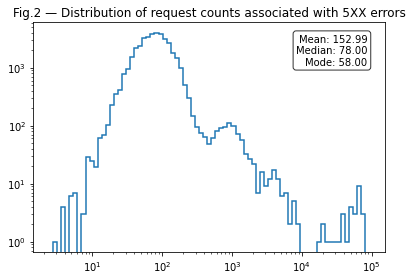

Saved Fig.2 -> userData/pivoted_paper_baseline_transformer_tf_with_gru_viz/fig2_5xx_distribution_transformer_tf.png


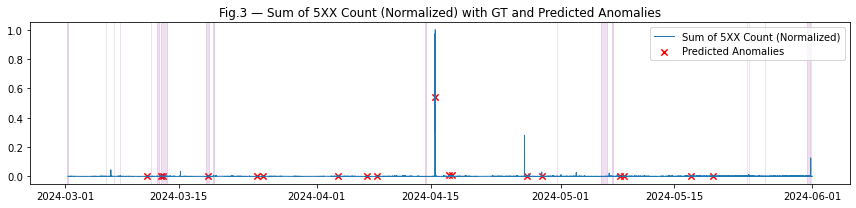

Saved Fig.3 -> userData/pivoted_paper_baseline_transformer_tf_with_gru_viz/fig3_sum5xx_norm_with_alerts_transformer.png


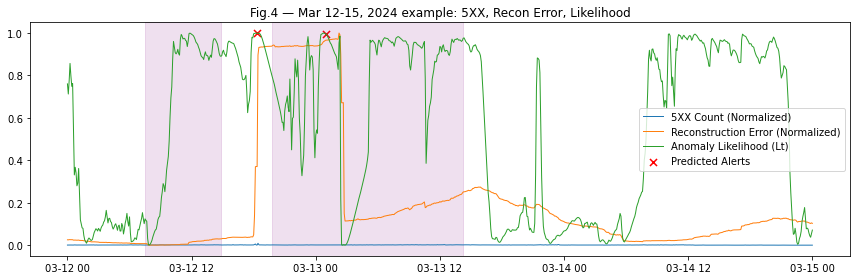

Saved Fig.4 -> userData/pivoted_paper_baseline_transformer_tf_with_gru_viz/fig4_mar12_15_transformer.png


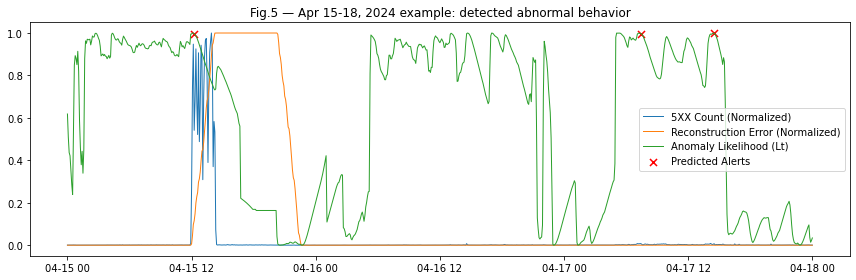

Saved Fig.5 -> userData/pivoted_paper_baseline_transformer_tf_with_gru_viz/fig5_apr15_18_transformer.png


/home/apps/anaconda3_2018/4.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError


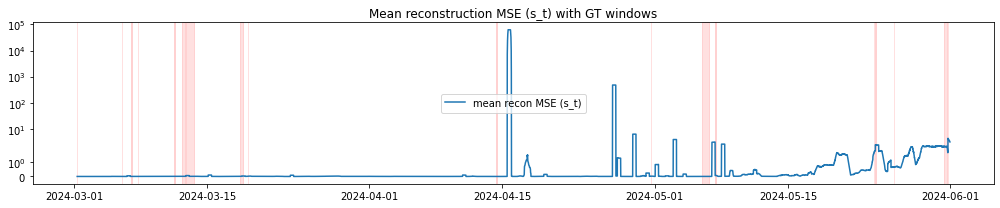

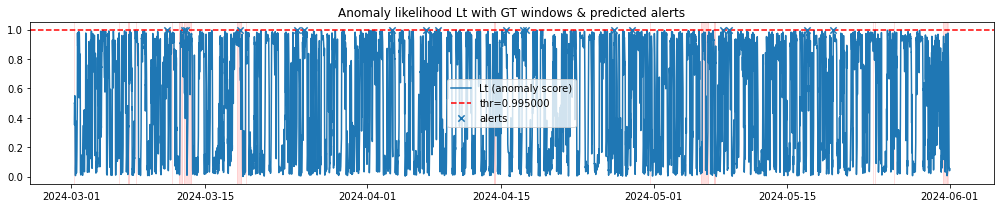


All figures saved to userData/pivoted_paper_baseline_transformer_tf_with_gru_viz
Done.


In [25]:

s_arr = all_rec_err.copy()
L_raw = L.copy()
seq_timestamps = pd.to_datetime(timestamps)

try: seq_timestamps = seq_timestamps.tz_localize(None)
except Exception: pass
minlen = min(len(s_arr), len(L_raw), len(seq_timestamps))
s_arr = s_arr[:minlen]
L_raw = L_raw[:minlen]
seq_timestamps = seq_timestamps[:minlen]

mse_series = pd.Series(s_arr, index=seq_timestamps)
lt_series = pd.Series(L_raw, index=seq_timestamps)
if 'df' in globals() and 'sum_5xx_count' in df.columns:
    sum_5xx = df['sum_5xx_count'].loc[seq_timestamps[0]:seq_timestamps[-1]].fillna(0)
    sum_norm = (sum_5xx - sum_5xx.min()) / (sum_5xx.max() - sum_5xx.min() + 1e-12)
else:
    sum_norm = pd.Series([], dtype=float)


def ema(x, alpha):
    out = np.empty_like(x, dtype=float)
    acc = 0.0
    for i, v in enumerate(x):
        acc = alpha * v + (1 - alpha) * acc if i else v
        out[i] = acc
    return out

def shaped_alerts(Ls, thr, cd, k_of_m=(2,3)):
    k, m = k_of_m
    above = (Ls >= thr)
    n = len(above)
    persisted = np.zeros_like(above, dtype=bool)
    for i in range(n):
        persisted[i] = (above[max(0, i-m+1):i+1].sum() >= k)
    trig = np.zeros_like(above, dtype=bool)
    i = 0
    while i < n:
        if persisted[i]:
            trig[i] = True
            i += cd
        else:
            i += 1
    return trig


VAL_START, VAL_END = pd.Timestamp("2024-03-01"), pd.Timestamp("2024-03-15 23:59:59")
tidx_arr = np.array(seq_timestamps)
val_mask = (tidx_arr >= np.datetime64(VAL_START)) & (tidx_arr <= np.datetime64(VAL_END))
t_val = tidx_arr[val_mask]
gt_val = gt_in_test[(gt_in_test['anomaly_end'] >= pd.Timestamp(t_val[0])) & (gt_in_test['anomaly_start'] <= pd.Timestamp(t_val[-1]))].reset_index(drop=True)

best = {"score": -1}
for alpha in [0.2, 0.3, 0.5]:
    Ls = ema(L_raw, alpha)
    L_val = Ls[val_mask]
    for k_of_m in [(2,3), (3,5)]:
        for cd in [12, 24, 36, 72]:
            for thr in np.linspace(0.995, 0.9999, 20):
                if len(L_val)==0:
                    continue
                pred_val = shaped_alerts(L_val, thr, cd, k_of_m)
                s, _ = nab_score_from_mask(pred_val, gt_val, pd.to_datetime(t_val), profile='standard', event_gap_minutes=cd, pct_prob=PCT_PROB)
                if s > best["score"]:
                    best = {"score": s, "alpha": alpha, "k_of_m": k_of_m, "cd": cd, "thr": thr}
if best["score"] < 0:
    best = {"alpha":0.3, "k_of_m":(2,3), "cd":24, "thr":PAPER_THR}

L_s = ema(L_raw, best["alpha"])
pred_full_mask = shaped_alerts(L_s, best["thr"], best["cd"], best["k_of_m"])
pred_series_shaped = pd.Series(pred_full_mask.astype(int), index=seq_timestamps)
events = mask_to_event_times(pred_full_mask, seq_timestamps, event_gap_minutes=best["cd"], pct_prob=PCT_PROB)
scores_df_smoothed = pd.DataFrame({"timestamp": seq_timestamps, "anomaly_score": L_s}).set_index("timestamp")


fig2_path = os.path.join(OUT_DIR, 'fig2_5xx_distribution_transformer_tf.png')
counts = df['sum_5xx_count'].fillna(0).values if 'df' in globals() and 'sum_5xx_count' in df.columns else np.array([])
plt.figure(figsize=(6,4))
if len(counts)>0:
    min_x = max(1, counts.min()+1)
    max_x = counts.max()+1
    bins = np.logspace(max(0, np.log10(min_x)-0.1), np.log10(max_x)+0.1, 80)
    plt.hist(counts + 1e-9, bins=bins, histtype='step', linewidth=1.5)
    plt.xscale('log'); plt.yscale('log')
    mean_v = counts.mean(); median_v = np.median(counts)
    try: mode_v = stats.mode(counts)[0][0]
    except: mode_v = np.nan
    plt.gca().text(0.95, 0.95, f"Mean: {mean_v:.2f}\nMedian: {median_v:.2f}\nMode: {mode_v:.2f}", transform=plt.gca().transAxes, va='top', ha='right', bbox=dict(boxstyle='round', fc='white', alpha=0.8))
plt.title('Fig.2 — Distribution of request counts associated with 5XX errors')
plt.tight_layout(); plt.savefig(fig2_path, dpi=150); plt.show()
print("Saved Fig.2 ->", fig2_path)


fig3_path = os.path.join(OUT_DIR, 'fig3_sum5xx_norm_with_alerts_transformer.png')
plt.figure(figsize=(12,3)); ax=plt.gca()
if not sum_norm.empty:
    ax.plot(sum_norm.index, sum_norm.values, label='Sum of 5XX Count (Normalized)', linewidth=1)

if gt_in_test is not None and not gt_in_test.empty:
    for _, r in gt_in_test.iterrows():
        s = pd.to_datetime(r['anomaly_start']).tz_localize(None) if hasattr(r['anomaly_start'],'tz') else pd.to_datetime(r['anomaly_start'])
        e = pd.to_datetime(r['anomaly_end']).tz_localize(None) if hasattr(r['anomaly_end'],'tz') else pd.to_datetime(r['anomaly_end'])
        ax.axvspan(s,e,color='purple',alpha=0.12)

if len(events):
    ev_idx = pd.to_datetime(events)
    try:
        interp_vals = np.interp(ev_idx.astype('int64'), sum_norm.index.astype('int64'), sum_norm.values)
        plt.scatter(ev_idx, interp_vals, marker='x', color='red', s=40, label='Predicted Anomalies')
    except Exception:
        plt.scatter(ev_idx, [0]*len(ev_idx), marker='x', color='red', s=40, label='Predicted Anomalies')
plt.title('Fig.3 — Sum of 5XX Count (Normalized) with GT and Predicted Anomalies'); plt.legend(loc='upper right'); plt.tight_layout(); plt.savefig(fig3_path, dpi=150); plt.show()
print("Saved Fig.3 ->", fig3_path)


fig4_path = os.path.join(OUT_DIR, 'fig4_mar12_15_transformer.png')
start4 = pd.Timestamp("2024-03-12"); end4 = pd.Timestamp("2024-03-15")
ix_sum = sum_norm.loc[start4:end4] if not sum_norm.empty else pd.Series([], dtype=float)
ix_mse = mse_series.loc[start4:end4] if not mse_series.empty else pd.Series([], dtype=float)
ix_lt  = lt_series.loc[start4:end4]  if not lt_series.empty else pd.Series([], dtype=float)
plt.figure(figsize=(12,4)); ax=plt.gca()
if not ix_sum.empty: ax.plot(ix_sum.index, ix_sum.values, label='5XX Count (Normalized)', linewidth=1)
if not ix_mse.empty: ax.plot(ix_mse.index, (ix_mse - ix_mse.min())/(ix_mse.max()-ix_mse.min()+1e-12), label='Reconstruction Error (Normalized)', linewidth=1)
if not ix_lt.empty:  ax.plot(ix_lt.index, ix_lt.values, label='Anomaly Likelihood (Lt)', linewidth=1)
ev_win = [e for e in events if (e >= start4) and (e <= end4)]
if len(ev_win) and not ix_lt.empty:
    vals = np.interp(pd.to_datetime(ev_win).astype('int64'), ix_lt.index.astype('int64'), ix_lt.values)
    plt.scatter(ev_win, vals, marker='x', color='red', s=50, label='Predicted Alerts')

if gt_in_test is not None and not gt_in_test.empty:
    ix_gt = gt_in_test[(gt_in_test['anomaly_start'] >= start4) & (gt_in_test['anomaly_start'] <= end4)]
    for _, r in ix_gt.iterrows():
        s = pd.to_datetime(r['anomaly_start']).tz_localize(None) if hasattr(r['anomaly_start'],'tz') else pd.to_datetime(r['anomaly_start'])
        e = pd.to_datetime(r['anomaly_end']).tz_localize(None) if hasattr(r['anomaly_end'],'tz') else pd.to_datetime(r['anomaly_end'])
        ax.axvspan(s,e,color='purple',alpha=0.12)
plt.title('Fig.4 — Mar 12-15, 2024 example: 5XX, Recon Error, Likelihood'); plt.legend(); plt.tight_layout(); plt.savefig(fig4_path, dpi=150); plt.show()
print("Saved Fig.4 ->", fig4_path)


fig5_path = os.path.join(OUT_DIR, 'fig5_apr15_18_transformer.png')
start5 = pd.Timestamp("2024-04-15"); end5 = pd.Timestamp("2024-04-18")
ix_sum = sum_norm.loc[start5:end5] if not sum_norm.empty else pd.Series([], dtype=float)
ix_mse = mse_series.loc[start5:end5] if not mse_series.empty else pd.Series([], dtype=float)
ix_lt  = lt_series.loc[start5:end5]  if not lt_series.empty else pd.Series([], dtype=float)
plt.figure(figsize=(12,4)); ax=plt.gca()
if not ix_sum.empty: ax.plot(ix_sum.index, ix_sum.values, label='5XX Count (Normalized)', linewidth=1)
if not ix_mse.empty: ax.plot(ix_mse.index, (ix_mse - ix_mse.min())/(ix_mse.max()-ix_mse.min()+1e-12), label='Reconstruction Error (Normalized)', linewidth=1)
if not ix_lt.empty:  ax.plot(ix_lt.index, ix_lt.values, label='Anomaly Likelihood (Lt)', linewidth=1)
ev_win = [e for e in events if (e >= start5) and (e <= end5)]
if len(ev_win) and not ix_lt.empty:
    vals = np.interp(pd.to_datetime(ev_win).astype('int64'), ix_lt.index.astype('int64'), ix_lt.values)
    plt.scatter(ev_win, vals, marker='x', color='red', s=50, label='Predicted Alerts')
if gt_in_test is not None and not gt_in_test.empty:
    ix_gt = gt_in_test[(gt_in_test['anomaly_start'] >= start5) & (gt_in_test['anomaly_start'] <= end5)]
    for _, r in ix_gt.iterrows():
        s = pd.to_datetime(r['anomaly_start']).tz_localize(None) if hasattr(r['anomaly_start'],'tz') else pd.to_datetime(r['anomaly_start'])
        e = pd.to_datetime(r['anomaly_end']).tz_localize(None) if hasattr(r['anomaly_end'],'tz') else pd.to_datetime(r['anomaly_end'])
        ax.axvspan(s,e,color='purple',alpha=0.12)
plt.title('Fig.5 — Apr 15-18, 2024 example: detected abnormal behavior'); plt.legend(); plt.tight_layout(); plt.savefig(fig5_path, dpi=150); plt.show()
print("Saved Fig.5 ->", fig5_path)


try:
    plt.figure(figsize=(14,3))
    plt.plot(mse_series, label='mean recon MSE (s_t)')
    if gt_in_test is not None and not gt_in_test.empty:
        for _, r in gt_in_test.iterrows():
            s = pd.to_datetime(r['anomaly_start']).tz_localize(None) if hasattr(r['anomaly_start'],'tz') else pd.to_datetime(r['anomaly_start'])
            e = pd.to_datetime(r['anomaly_end']).tz_localize(None) if hasattr(r['anomaly_end'],'tz') else pd.to_datetime(r['anomaly_end'])
            plt.axvspan(s,e,color='red', alpha=0.12)
    plt.yscale('symlog', linthresh=1e-6)
    plt.title('Mean reconstruction MSE (s_t) with GT windows'); plt.legend(); plt.tight_layout()
    plt.show()
except Exception as e:
    print('MSE plot error (ignored):', e)

try:
    plt.figure(figsize=(14,3))
    plt.plot(scores_df_smoothed.index, scores_df_smoothed['anomaly_score'], label='Lt (anomaly score)')
    plt.axhline(best["thr"], color='red', linestyle='--', label=f'thr={best["thr"]:.6f}')
    if gt_in_test is not None and not gt_in_test.empty:
        for _, r in gt_in_test.iterrows():
            s = pd.to_datetime(r['anomaly_start']).tz_localize(None) if hasattr(r['anomaly_start'],'tz') else pd.to_datetime(r['anomaly_start'])
            e = pd.to_datetime(r['anomaly_end']).tz_localize(None) if hasattr(r['anomaly_end'],'tz') else pd.to_datetime(r['anomaly_end'])
            plt.axvspan(s,e,color='red',alpha=0.12)
    ev_dt = pd.to_datetime(events)
    if len(ev_dt):
        plt.scatter(ev_dt, [best["thr"]]*len(ev_dt), marker='x', s=40, label='alerts', zorder=5)
    plt.title('Anomaly likelihood Lt with GT windows & predicted alerts')
    plt.legend(); plt.tight_layout(); plt.show()
except Exception as e:
    print('Score plot error (ignored):', e)

print("\nAll figures saved to", OUT_DIR)
print("Done.")